# Packages

In [1]:
! pip install lifelines scikit-survival survshap shap jinja2 survinsights seaborn numba numpy==1.23.5 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from sksurv.util import Surv
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import integrated_brier_score
from sksurv.metrics import concordance_index_censored

from lifelines import CoxPHFitter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import fonctions_SurvTreeShap as fstp

from survshap import SurvivalModelExplainer, PredictSurvSHAP

/Users/gillesfevry/.pyenv/versions/3.10.12/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [50]:
import importlib
importlib.reload(fstp)

<module 'fonctions_SurvTreeShap' from '/Users/gillesfevry/Surv-ML-1/fonctions_SurvTreeShap.py'>

# Données

In [4]:
data = pd.read_csv("METABRIC_RNA_Mutation.csv")
data

/var/folders/9l/n7yv83fn1l5_xstw36wkw_3m0000gn/T/ipykernel_113/1434437314.py:1: DtypeWarning: Columns (678,688,690,692) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("METABRIC_RNA_Mutation.csv")


,patient_id,age_at_diagnosis,type_of_breast_surgery,cancer_type,cancer_type_detailed,cellularity,chemotherapy,pam50_+_claudin-low_subtype,cohort,er_status_measured_by_ihc,...,mtap_mut,ppp2cb_mut,smarcd1_mut,nras_mut,ndfip1_mut,hras_mut,prps2_mut,smarcb1_mut,stmn2_mut,siah1_mut
0,0,75.65,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,NaN,0,claudin-low,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
1,2,43.19,BREAST CONSERVING,Breast Cancer,Breast Invasive Ductal Carcinoma,High,0,LumA,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
2,5,48.87,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
3,6,47.68,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,Moderate,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
4,8,76.97,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,High,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1899,7295,43.10,BREAST CONSERVING,Breast Cancer,Breast Invasive Lobular Carcinoma,High,0,LumA,4.0,Positve,...,0,0,0,0,0,0,0,0,0,0
1900,7296,42.88,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,0,LumB,4.0,Positve,...,0,0,0,0,0,0,0,0,0,0
1901,7297,62.90,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,0,LumB,4.0,Positve,...,0,0,0,0,0,0,0,0,0,0
1902,7298,61.16,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,Moderate,0,LumB,4.0,Positve,...,0,0,0,0,0,0,0,0,0,0


In [5]:
colones_00 = data.columns[520:]  # colones dont on veut faire passer 0 à "0", a partir de la colone "pik3ca_mut"
data[colones_00] = data[colones_00].astype(str)
data[colones_00] = data[colones_00].applymap(lambda x: 0 if x == "0" else 1)

/var/folders/9l/n7yv83fn1l5_xstw36wkw_3m0000gn/T/ipykernel_113/1479749344.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data[colones_00] = data[colones_00].applymap(lambda x: 0 if x == "0" else 1)


In [6]:
for col in data.select_dtypes(include=['object']).columns:
    data[col] = LabelEncoder().fit_transform(data[col])

In [7]:
y = data[["death_from_cancer", "overall_survival_months"]]
y['Died_of_Desease'] = (y['death_from_cancer'] == 0).astype(int)
y=y.drop("death_from_cancer", axis=1)
y.head()

/var/folders/9l/n7yv83fn1l5_xstw36wkw_3m0000gn/T/ipykernel_113/1315501560.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['Died_of_Desease'] = (y['death_from_cancer'] == 0).astype(int)


,overall_survival_months,Died_of_Desease
0,140.500000,0
1,84.633333,0
2,163.700000,1
3,164.933333,0
4,41.366667,1


In [8]:
X = data.drop(columns=["death_from_cancer", "overall_survival_months", "overall_survival"]) 
X

,patient_id,age_at_diagnosis,type_of_breast_surgery,cancer_type,cancer_type_detailed,cellularity,chemotherapy,pam50_+_claudin-low_subtype,cohort,er_status_measured_by_ihc,...,mtap_mut,ppp2cb_mut,smarcd1_mut,nras_mut,ndfip1_mut,hras_mut,prps2_mut,smarcb1_mut,stmn2_mut,siah1_mut
0,0,75.65,1,0,1,3,0,6,1.0,1,...,0,0,0,0,0,0,0,0,0,0
1,2,43.19,0,0,1,0,0,2,1.0,1,...,0,0,0,0,0,0,0,0,0,0
2,5,48.87,1,0,1,0,1,3,1.0,1,...,0,0,0,0,0,0,0,0,0,0
3,6,47.68,1,0,4,2,1,3,1.0,1,...,0,0,0,0,0,0,0,0,0,0
4,8,76.97,1,0,4,0,1,3,1.0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1899,7295,43.10,0,0,2,0,0,2,4.0,1,...,0,0,0,0,0,0,0,0,0,0
1900,7296,42.88,1,0,1,0,0,3,4.0,1,...,0,0,0,0,0,0,0,0,0,0
1901,7297,62.90,1,0,1,0,0,3,4.0,1,...,0,0,0,0,0,0,0,0,0,0
1902,7298,61.16,1,0,1,2,0,3,4.0,1,...,0,0,0,0,0,0,0,0,0,0


# Dataset entier

## RSF

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
y_train_RSF = Surv.from_dataframe("Died_of_Desease", "overall_survival_months", y_train)
y_test_RSF = Surv.from_dataframe("Died_of_Desease", "overall_survival_months", y_test)

In [11]:
rsf = RandomSurvivalForest(n_estimators=100, random_state=42, max_depth=3)
rsf.fit(X_train, y_train_RSF)

RandomSurvivalForest(max_depth=3, random_state=42)

## Performance

In [12]:
times = np.arange(2, 337)

In [13]:
# Prédire les fonctions de survie
survs = rsf.predict_survival_function(X_test)

preds = np.asarray([[fn(t) for t in times] for fn in survs])
score = integrated_brier_score(y_train_RSF, y_test_RSF, preds, times)
print(score)

0.17259456392030215


In [14]:
y_pred_rsf = rsf.predict(X_test)
c_index = concordance_index_censored(y_test_RSF["Died_of_Desease"], y_test_RSF["overall_survival_months"], y_pred_rsf)[0]
c_index

0.7271034563016409

## Résultats

100%|██████████| 1374/1374 [00:01<00:00, 841.94it/s]


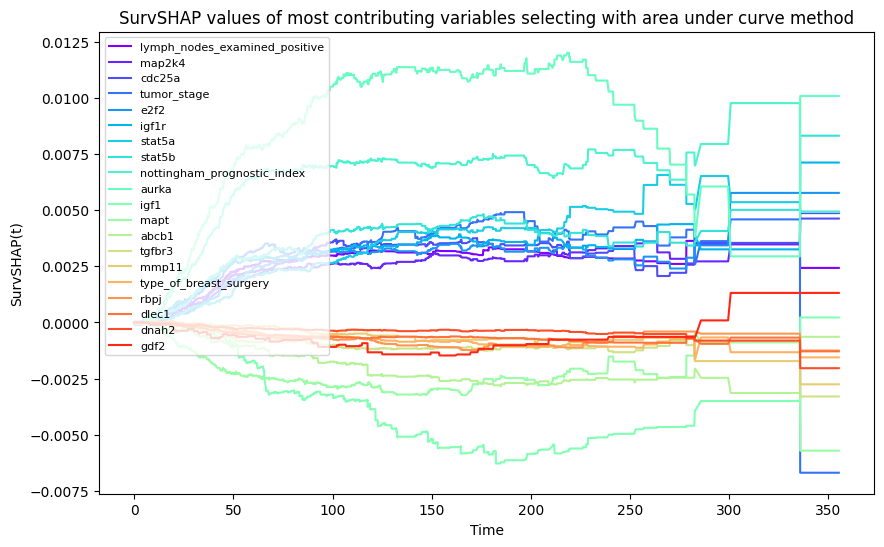

In [33]:
STS=fstp.SurvTreeSHAPexplainer(rsf, X_test)
STS.plotgraph(0, "area", 10, 10)

100%|██████████| 1374/1374 [00:01<00:00, 1154.02it/s]
/Users/gillesfevry/Surv-ML-1/fonctions_SurvTreeShap.py:157: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


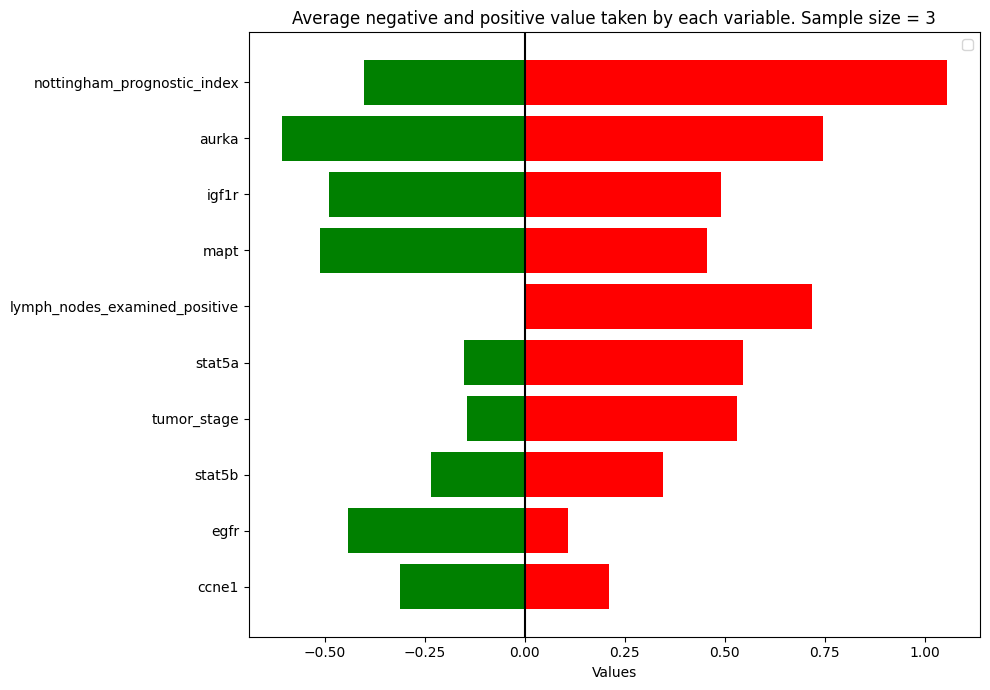

In [35]:
STS.averagesurvshap(3, 10)

# Comutation PIK3CA-TP53 et comparaison à un modèle de COX

papier de référence https://pmc.ncbi.nlm.nih.gov/articles/PMC10475711/

## Préparation des données

In [19]:
data_comp= data
#data_comp = data.dropna(subset=['tumor_stage'])
X_comp= data_comp[["age_at_diagnosis", "tumor_stage", 'er_status', "her2_status", "pik3ca_mut", "tp53_mut"]]
X_comp['comutation'] = ((X_comp['pik3ca_mut'] == 1) & (X_comp['tp53_mut'] == 1)).astype(int)
X_comp['pik3ca_mut_only'] = ((X_comp['pik3ca_mut'] == 1) & (X_comp['tp53_mut'] == 0)).astype(int)
X_comp['tp53_mut_only'] = ((X_comp['tp53_mut'] == 1) & (X_comp['pik3ca_mut'] == 0)).astype(int)
nan_ilocs = np.where(X_comp['tumor_stage'].isna())[0]
X_comp['tumor_stage_NAN'] = (X_comp['tumor_stage'].isna()).astype(int) ##
#xys=(X_comp['tumor_stage'] == 0).astype(int).sum()
#print(xys)
X_comp = pd.get_dummies(X_comp, columns=['tumor_stage']).astype(float)
X_comp = X_comp.drop(columns=['pik3ca_mut', "tp53_mut", 'tumor_stage_0.0'])
X_comp


/var/folders/9l/n7yv83fn1l5_xstw36wkw_3m0000gn/T/ipykernel_113/843247338.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_comp['comutation'] = ((X_comp['pik3ca_mut'] == 1) & (X_comp['tp53_mut'] == 1)).astype(int)
/var/folders/9l/n7yv83fn1l5_xstw36wkw_3m0000gn/T/ipykernel_113/843247338.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_comp['pik3ca_mut_only'] = ((X_comp['pik3ca_mut'] == 1) & (X_comp['tp53_mut'] == 0)).astype(int)
/var/folders/9l/n7yv83fn1l5_xstw36wkw_3m0000gn/T/ipykernel_113/84324733

,age_at_diagnosis,er_status,her2_status,comutation,pik3ca_mut_only,tp53_mut_only,tumor_stage_NAN,tumor_stage_1.0,tumor_stage_2.0,tumor_stage_3.0,tumor_stage_4.0
0,75.65,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,43.19,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,48.87,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,47.68,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,76.97,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1899,43.10,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1900,42.88,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
1901,62.90,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1902,61.16,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [20]:
y_comp = data_comp[["death_from_cancer", "overall_survival_months"]]
y_comp['Died_of_Desease'] = (y_comp['death_from_cancer'] == 0).astype(int)
y_comp=y_comp.drop("death_from_cancer", axis=1)

/var/folders/9l/n7yv83fn1l5_xstw36wkw_3m0000gn/T/ipykernel_113/2958538285.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_comp['Died_of_Desease'] = (y_comp['death_from_cancer'] == 0).astype(int)


In [21]:
X_comp_train, X_comp_test, y_comp_train, y_comp_test = train_test_split(X_comp, y_comp, test_size=0.2, random_state=42)
y_comp_train_RSF = Surv.from_dataframe("Died_of_Desease", "overall_survival_months", y_comp_train)
y_comp_test_RSF = Surv.from_dataframe("Died_of_Desease", "overall_survival_months", y_comp_test)

In [22]:
comutés = X_comp_test[X_comp_test["comutation"] == 1]

## Comparaison des modèles

### Modèle de Cox

In [23]:
data_for_cox= pd.concat([X_comp_train, y_comp_train], axis=1)
cph = CoxPHFitter()
cph.fit(data_for_cox, duration_col='overall_survival_months', event_col='Died_of_Desease')

# Résumé du modèle
cph.print_summary()

/Users/gillesfevry/.pyenv/versions/3.10.12/lib/python3.10/site-packages/lifelines/fitters/coxph_fitter.py:1607: ConvergenceWarning: Newton-Raphson convergence completed successfully but norm(delta) is still high, 0.828. This may imply non-unique solutions to the maximum likelihood. Perhaps there is collinearity or complete separation in the dataset?

  warnings.warn(


<lifelines.CoxPHFitter: fitted with 1523 total observations, 1029 right-censored observations>
             duration col = 'overall_survival_months'
                event col = 'Died_of_Desease'
      baseline estimation = breslow
   number of observations = 1523
number of events observed = 494
   partial log-likelihood = -3292.84
         time fit was run = 2025-04-30 20:44:00 UTC

---
                  coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                         
age_at_diagnosis  0.01      1.01      0.00            0.00            0.02                1.00                1.02
er_status        -0.24      0.79      0.13           -0.49            0.01                0.61                1.01
her2_status       0.44      1.55      0.13            0.19            0.69                1.21                1.99
comutation        0.76      2.14      0.14            0.48            1.04                1.61                2.84
pik3ca_mut_only   0.02      1.02      0.12           -0.22            0.26                0.81                1.29
tp53_mut_only     0.17      1.19      0.14           -0.10            0.44                0.90                1.56
tumor_stage_NAN  13.24  5.64e+05    719.72        -1397.39         1423.87                0.00                 inf
tumor_stage_1.0  12.76  3.48e+05    719.72        -1397.87         1423.39                0.00                 inf
tumor_stage_2.0  13.42  6.75e+05    719.72        -1397.21         1424.06                0.00                 inf
tumor_stage_3.0  14.14  1.38e+06    719.72        -1396.49         1424.77                0.00                 inf
tumor_stage_4.0  14.76  2.57e+06    719.72        -1395.87         1425.39                0.00                 inf

                  cmp to     z      p  -log2(p)
covariate                                      
age_at_diagnosis    0.00  2.71   0.01      7.23
er_status           0.00 -1.87   0.06      4.03
her2_status         0.00  3.43 <0.005     10.72
comutation          0.00  5.27 <0.005     22.81
pik3ca_mut_only     0.00  0.18   0.86      0.22
tp53_mut_only       0.00  1.23   0.22      2.20
tumor_stage_NAN     0.00  0.02   0.99      0.02
tumor_stage_1.0     0.00  0.02   0.99      0.02
tumor_stage_2.0     0.00  0.02   0.99      0.02
tumor_stage_3.0     0.00  0.02   0.98      0.02
tumor_stage_4.0     0.00  0.02   0.98      0.02
---
Concordance = 0.67
Partial AIC = 6607.67
log-likelihood ratio test = 151.91 on 11 df
-log2(p) of ll-ratio test = 87.09

In [24]:
y_comp_pred_cox = cph.predict_partial_hazard(X_comp_test)
c_index_cox = concordance_index_censored(y_comp_test_RSF["Died_of_Desease"], y_comp_test_RSF["overall_survival_months"], y_comp_pred_cox)[0]
c_index_cox

0.6638252065634819

In [25]:
times = np.arange(2, 337)
surv_pred_cox = cph.predict_survival_function(X_comp_test, times=times).T.to_numpy()  
score_cox = integrated_brier_score(y_comp_train_RSF, y_comp_test_RSF, surv_pred_cox, times)
score_cox

0.16517816449787176

### Modèle RSF

In [26]:
rsf_comp = RandomSurvivalForest(n_estimators=100, random_state=42, max_depth=3)
rsf_comp.fit(X_comp_train, y_comp_train_RSF)

RandomSurvivalForest(max_depth=3, random_state=42)

In [27]:
y_comp_pred_rsf = rsf_comp.predict(X_comp_test)
c_index_rsf = concordance_index_censored(y_comp_test_RSF["Died_of_Desease"], y_comp_test_RSF["overall_survival_months"], y_comp_pred_rsf)[0]
c_index_rsf

0.6727132549749796

In [28]:
surv_func_pred_rsf = rsf_comp.predict_survival_function(X_comp_test)
preds = np.asarray([[fn(t) for t in times] for fn in surv_func_pred_rsf])
score = integrated_brier_score(y_comp_train_RSF, y_comp_test_RSF, preds, times)
score

0.17511345421112126

## L'importance de la comutation pour la RSF

### Comparaison de SurvTreeSHAP et KernelSurvSHAP

100%|██████████| 1374/1374 [00:01<00:00, 994.59it/s] 


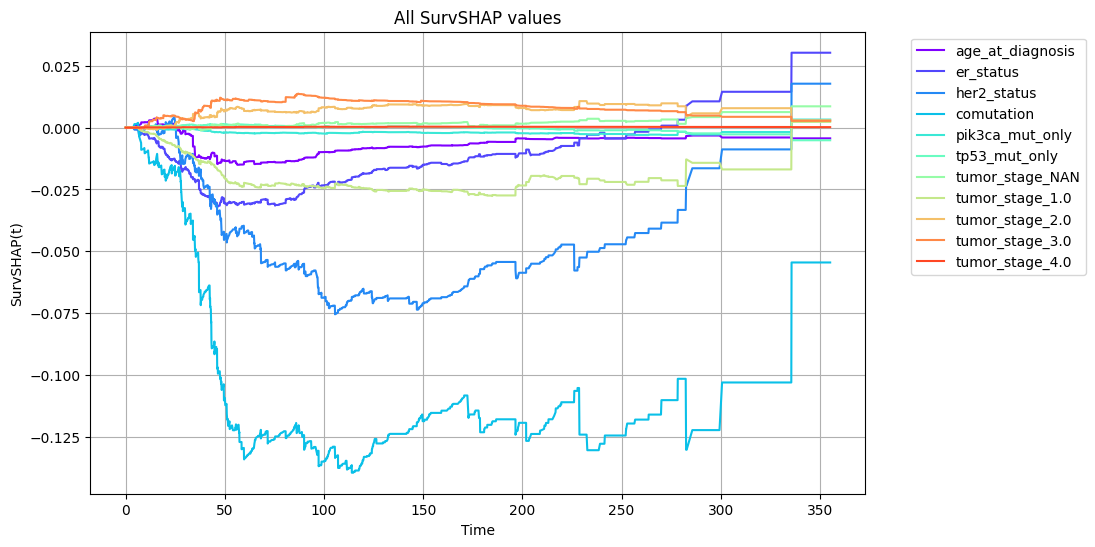

In [56]:
# SurvTreeSHAP

STS_com= fstp.SurvTreeSHAPexplainer(rsf_comp, comutés)
STS_com.plotgraph(2)

In [ ]:
#ce code utilise KernelSHAP pour calculer SurvSHAP.
#Il prend une vingtaine de minutes à tourner.
#Pour le faire tourner, remplacer false par True

if False:
    # create explainer
    explainer = SurvivalModelExplainer(model = rsf_comp, data = X_comp_train, y = y_comp_train_RSF)

    # compute SHAP values for a single instance
    observation_A = comutés.iloc[[2]]
    survshap_A = PredictSurvSHAP()
    survshap_A.fit(explainer = explainer, new_observation = observation_A)

    df=survshap_A.result 

    # On sélectionne les colonnes temporelles (celles qui commencent par "t =")
    time_cols = [col for col in df.columns if col.startswith("t =")]

    # On convertit ces colonnes en float pour les trier correctement
    time_values = [float(col.replace("t = ", "")) for col in time_cols]

    # Tracé
    plt.figure(figsize=(12, 6))

    for i, row in df.iterrows():
        contribs = row[time_cols].values.astype(float)
        plt.plot(time_values, contribs, label=row["variable_name"])

    plt.xlabel("Time")
    plt.ylabel("SurvSHAP(t)")
    plt.title("All SurvSHAP values")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.grid(True)
    plt.show()


100%|██████████| 1374/1374 [00:01<00:00, 1047.59it/s]


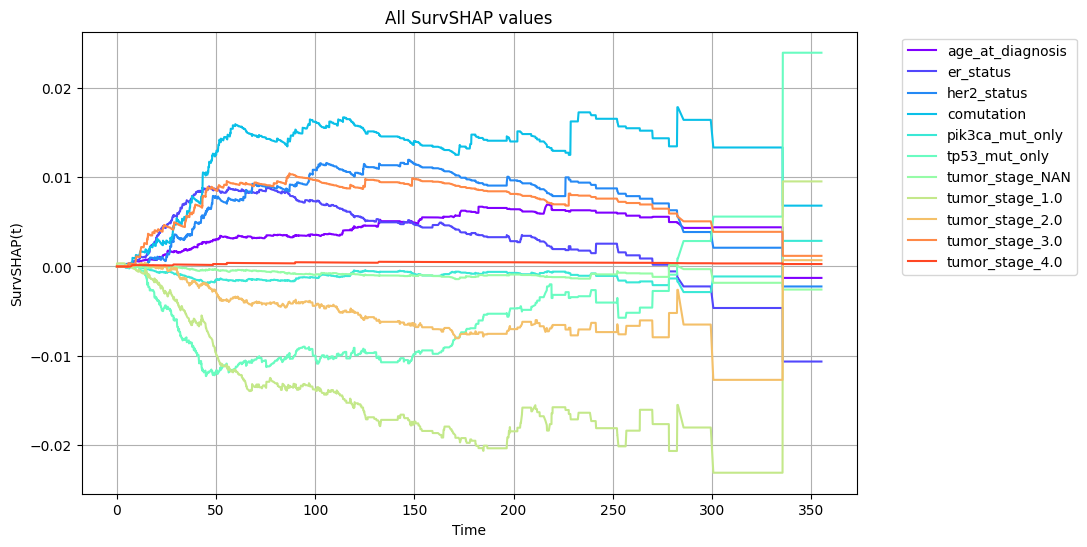

In [ ]:
#SurvTreeSHAP pour une patiente au hasard

STS_comp= fstp.SurvTreeSHAPexplainer(rsf_comp, X_comp_test)
STS_comp.plotgraph(5)

### Classement des variables

100%|██████████| 1374/1374 [00:01<00:00, 1092.48it/s]
/Users/gillesfevry/Surv-ML-1/fonctions_SurvTreeShap.py:161: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



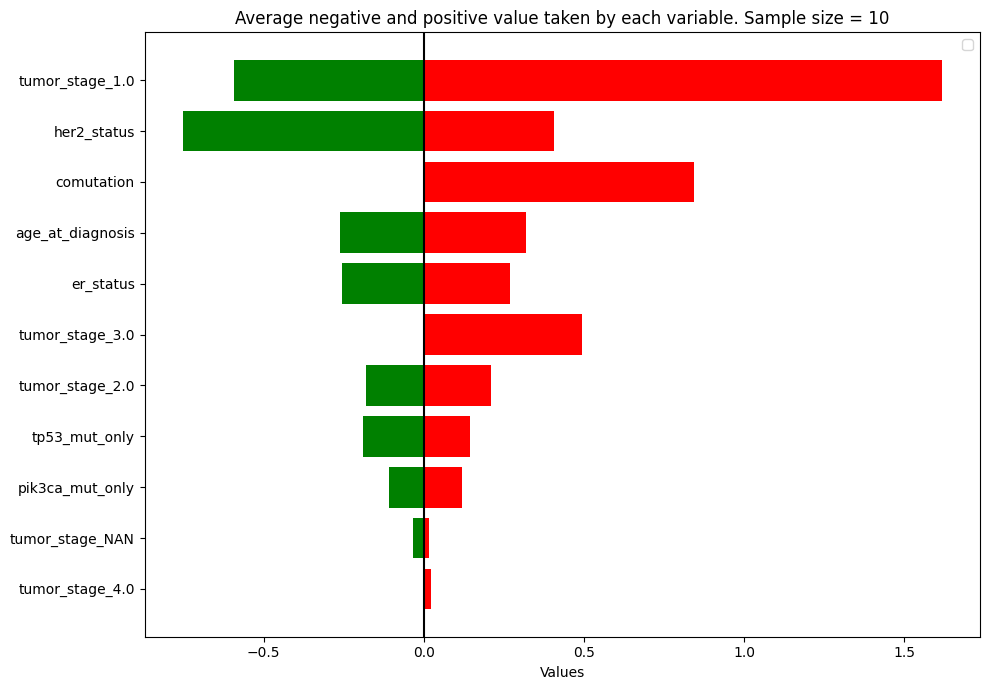

In [62]:

STS_comp.averagesurvshap(10)

100%|██████████| 1374/1374 [00:01<00:00, 1087.22it/s]


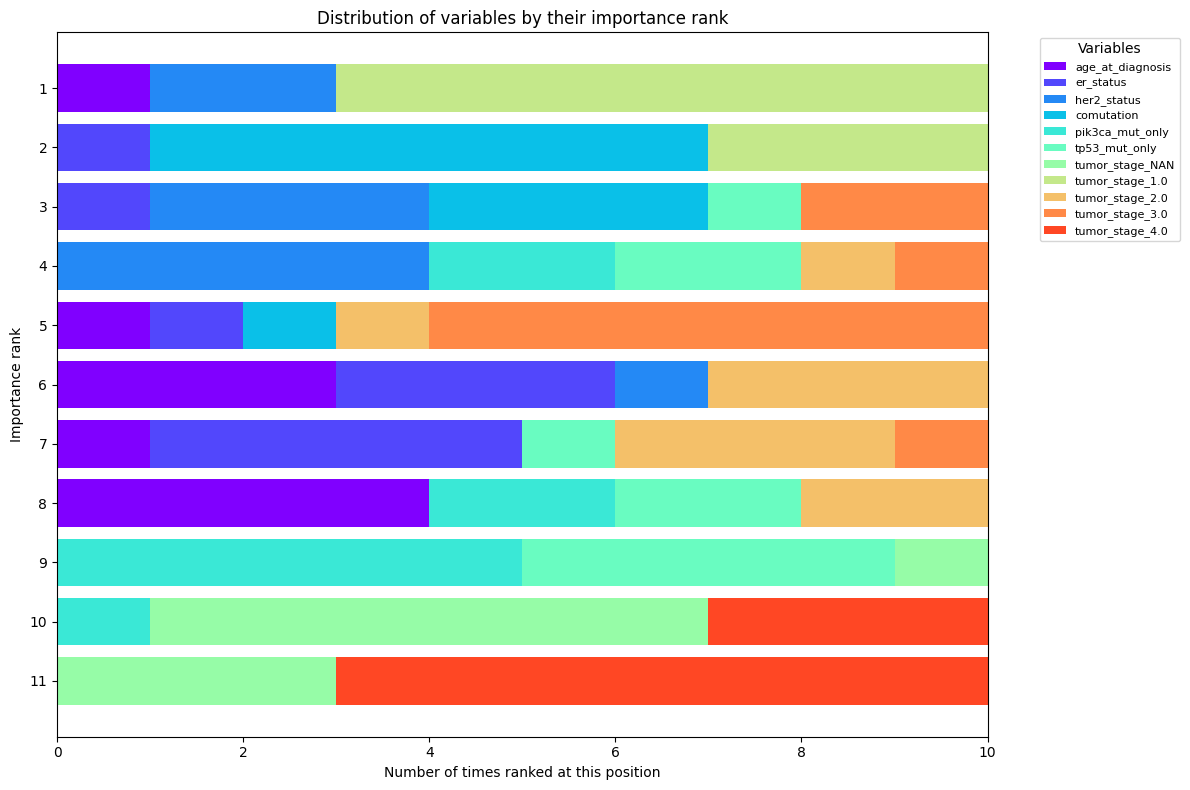

In [63]:
STS_comp.rankvariables(10)